Dataset: http://mmlab.ie.cuhk.edu.hk/projects/DeepFashion.html 

In [ ]:

!pip install fastai
!pip install annoy
!pip install gdown

     |████████████████████████████████| 645kB 2.8MB/s 
  Created wheel for annoy: filename=annoy-1.16.3-cp36-cp36m-linux_x86_64.whl size=297320 sha256=bea8982db5bdba338840658ad4d97abbe5764a8649eb50979a1c725fdd70e4c7
  Stored in directory: /root/.cache/pip/wheels/f3/01/54/6ef760fe9f9fc6ba8c19cebbe6358212b5f3b5b0195c0b813f
Successfully built annoy


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gdown
from fastai.vision import *
from fastai.metrics import accuracy, top_k_accuracy
from annoy import AnnoyIndex
import zipfile
import time
from google.colab import drive
%matplotlib inline


In [ ]:
root_path = './'
url = 'https://drive.google.com/uc?id=1j5fCPgh0gnY6v7ChkWlgnnHH6unxuAbb'
output = 'img.zip'
gdown.download(url, output, quiet=False)
with zipfile.ZipFile("img.zip","r") as zip_ref:
    zip_ref.extractall(root_path)

Downloading...
From: https://drive.google.com/uc?id=1j5fCPgh0gnY6v7ChkWlgnnHH6unxuAbb
To: /content/img.zip
2.68GB [01:04, 41.8MB/s]


In [ ]:
category_list = []
image_path_list = []
data_type_list = []
# category names
with open('list_category_cloth.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            category_list.append(line.split(' ')[0])

# category map
with open('list_category_img.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            image_path_list.append([word.strip() for word in line.split(' ') if len(word) > 0])


# train, valid, test
with open('list_eval_partition.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            data_type_list.append([word.strip() for word in line.split(' ') if len(word) > 0])

In [ ]:
data_df = pd.DataFrame(image_path_list, columns=['image_path', 'category_number'])
data_df['category_number'] = data_df['category_number'].astype(int)
data_df = data_df.merge(pd.DataFrame(data_type_list, columns=['image_path', 'dataset_type']), on='image_path')
data_df['category'] = data_df['category_number'].apply(lambda x: category_list[int(x) - 1])
data_df = data_df.drop('category_number', axis=1)


,image_path,dataset_type,category
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,train,Blouse
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,train,Blouse
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,val,Blouse
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,train,Blouse
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,test,Blouse


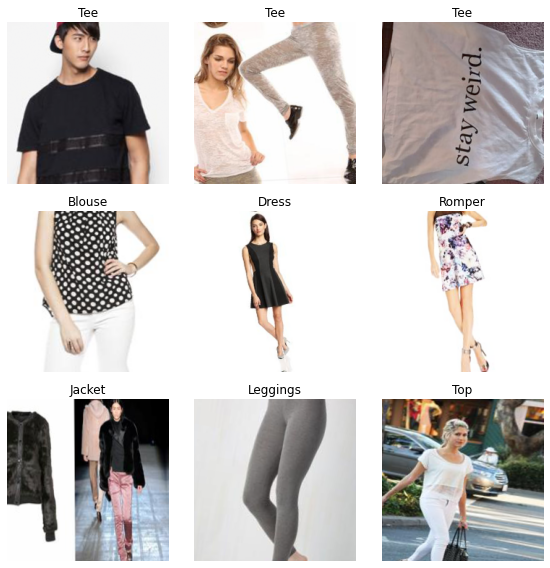

In [ ]:
train_image_list = ImageList.from_df(df=data_df, path=root_path, cols='image_path').split_by_idxs(
    (data_df[data_df['dataset_type']=='train'].index),
    (data_df[data_df['dataset_type']=='val'].index)).label_from_df(cols='category')
test_image_list = ImageList.from_df(df=data_df[data_df['dataset_type'] == 'test'], path=root_path, cols='image_path')

data = train_image_list.transform(get_transforms(), size=224).databunch(bs=128).normalize(imagenet_stats)
data.add_test(test_image_list)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-03
Min loss divided by 10: 1.00E-02


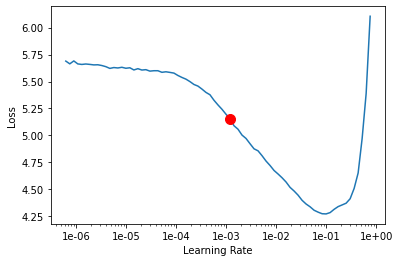

In [ ]:
def train_model(data, pretrained_model, model_metrics):
    learner = cnn_learner(data, pretrained_model, metrics=model_metrics)
    learner.model = torch.nn.DataParallel(learner.model)
    learner.lr_find()
    return learner

pretrained_model = models.resnet18 
model_metrics = [accuracy, partial(top_k_accuracy, k=1), partial(top_k_accuracy, k=5)]
learner = train_model(data, pretrained_model, model_metrics)

In [ ]:
learner.fit_one_cycle(10, max_lr=1e-02)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,time
0,1.471898,1.353760,0.602250,0.602250,0.897625,16:54
1,1.451260,1.388633,0.593200,0.593200,0.891875,16:19
2,1.440240,1.380244,0.594750,0.594750,0.894000,16:32
3,1.409721,1.315045,0.610425,0.610425,0.905450,16:39
4,1.335867,1.257601,0.634525,0.634525,0.911550,16:36
5,1.315253,1.238566,0.639000,0.639000,0.915575,16:48
6,1.275752,1.166933,0.658325,0.658325,0.923950,17:06
7,1.228926,1.135368,0.664400,0.664400,0.926100,17:09


Buffered data was truncated after reaching the output size limit.

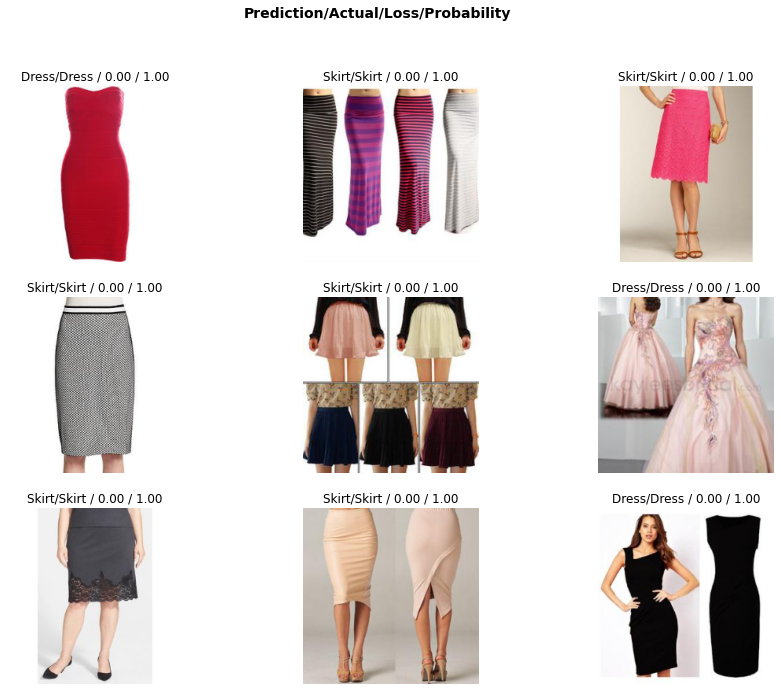

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_top_losses(9, largest=False, figsize=(15,11), heatmap_thresh=5)

In [ ]:

drive.mount('/content/gdrive')
learner.save('/content/gdrive/My Drive/resnet18-fashion')

In [ ]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()

In [ ]:
def load_learner(data, pretrained_model, model_metrics, model_path):
    learner = cnn_learner(data, pretrained_model, metrics=model_metrics)
    learner.model = torch.nn.DataParallel(learner.model)
    learner = learner.load(model_path)
    return learner

pretrained_model = models.resnet18 

model_metrics = [accuracy, partial(top_k_accuracy, k=1), partial(top_k_accuracy, k=5)]
drive.mount('/content/gdrive') 


model_path = "/content/gdrive/My Drive/resnet18-fashion"
learner = load_learner(data, pretrained_model, model_metrics, model_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
saved_features = SaveFeatures(learner.model.module[1][4])
_= learner.get_preds(data.train_ds)
_= learner.get_preds(DatasetType.Valid)

In [ ]:
img_path = [str(x) for x in (list(data.train_ds.items) +list(data.valid_ds.items))]
label = [data.classes[x] for x in (list(data.train_ds.y.items) +list(data.valid_ds.y.items))]
label_id = [x for x in (list(data.train_ds.y.items) +list(data.valid_ds.y.items))]
data_df_ouput = pd.DataFrame({'img_path': img_path, 'label': label, 'label_id': label_id})
data_df_ouput['embeddings'] = np.array(saved_features.features).tolist()


,img_path,label,label_id,embeddings
0,./img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,Blouse,2,"[121.6978759765625, 16.4276180267334, 11.58070..."
1,./img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,Blouse,2,"[36.95730972290039, -3.8367443084716797, 108.2..."
2,./img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,Blouse,2,"[41.468257904052734, -106.45553588867188, -79...."
3,./img/Sheer_Pleated-Front_Blouse/img_00000008.jpg,Blouse,2,"[-7.797255039215088, 64.00598907470703, 98.846..."
4,./img/Sheer_Pleated-Front_Blouse/img_00000009.jpg,Blouse,2,"[-1.5114988088607788, 3.284604072570801, 39.44..."
...,...,...,...,...
249217,./img/Paisley_Print_Babydoll_Dress/img_0000003...,Dress,13,"[-9.70374584197998, -61.290283203125, -72.0256..."
249218,./img/Paisley_Print_Babydoll_Dress/img_0000004...,Dress,13,"[-60.37247848510742, -74.62104034423828, -86.3..."
249219,./img/Paisley_Print_Babydoll_Dress/img_0000004...,Dress,13,"[-93.82817077636719, 68.36385345458984, -26.60..."
249220,./img/Paisley_Print_Babydoll_Dress/img_0000004...,Dress,13,"[-52.77716064453125, 52.109893798828125, -175...."


In [ ]:

def get_similar_images_annoy(annoy_tree, img_index, number_of_items=12):
    start = time.time()
    img_id, img_label  = data_df_ouput.iloc[img_index, [0, 1]]
    similar_img_ids = annoy_tree.get_nns_by_item(img_index, number_of_items+1)
    end = time.time()
    print(f'{(end - start) * 1000} ms')
    return img_id, img_label, data_df_ouput.iloc[similar_img_ids[1:]] 

def get_similar_images_annoy_centroid(annoy_tree, vector_value, number_of_items=12):
    start = time.time()
    similar_img_ids = annoy_tree.get_nns_by_vector(vector_value, number_of_items+1)
    end = time.time()
    print(f'{(end - start) * 1000} ms')
    return data_df_ouput.iloc[similar_img_ids[1:]] 


def show_similar_images(similar_images_df, fig_size=[10,10], hide_labels=True):
    if hide_labels:
        category_list = []
        for i in range(len(similar_images_df)):
            category_list.append(CategoryList(similar_images_df['label_id'].values*0,
                                              [''] * len(similar_images_df)).get(i))
    else:
        category_list = [learner.data.train_ds.y.reconstruct(y) for y in similar_images_df['label_id']]
    return learner.data.show_xys([open_image(img_id) for img_id in similar_images_df['img_path']],
                                category_list, figsize=fig_size)

In [ ]:
ntree = 100
metric_choice = 'angular'

annoy_tree = AnnoyIndex(len(data_df_ouput['embeddings'][0]), metric=metric_choice)
for i, vector in enumerate(data_df_ouput['embeddings']):
    annoy_tree.add_item(i, vector)
_  = annoy_tree.build(ntree)

In [ ]:
def centroid_embedding(outfit_embedding_list):
    number_of_outfits = outfit_embedding_list.shape[0]
    length_of_embedding = outfit_embedding_list.shape[1]
    centroid = []
    for i in range(length_of_embedding):
        centroid.append(np.sum(outfit_embedding_list[:, i])/number_of_outfits)
    return centroid

In [ ]:
#the list is generated from purchase history/ quiz results/ imput images

outfit_img_ids = [171787, 168315, 194847,244804, 153507, 166507, 172396, 14497, 200965, 162629,241277, 126155]
outfit_embedding_list = []
for img_index in outfit_img_ids:
    outfit_embedding_list.append(data_df_ouput.iloc[img_index, 3])

outfit_embedding_list = np.array(outfit_embedding_list)
outfit_centroid_embedding = centroid_embedding(outfit_embedding_list)
outfits_selected = data_df_ouput.iloc[outfit_img_ids] 

similar_images_df = get_similar_images_annoy_centroid(annoy_tree, outfit_centroid_embedding, 30)

2.0258426666259766 ms


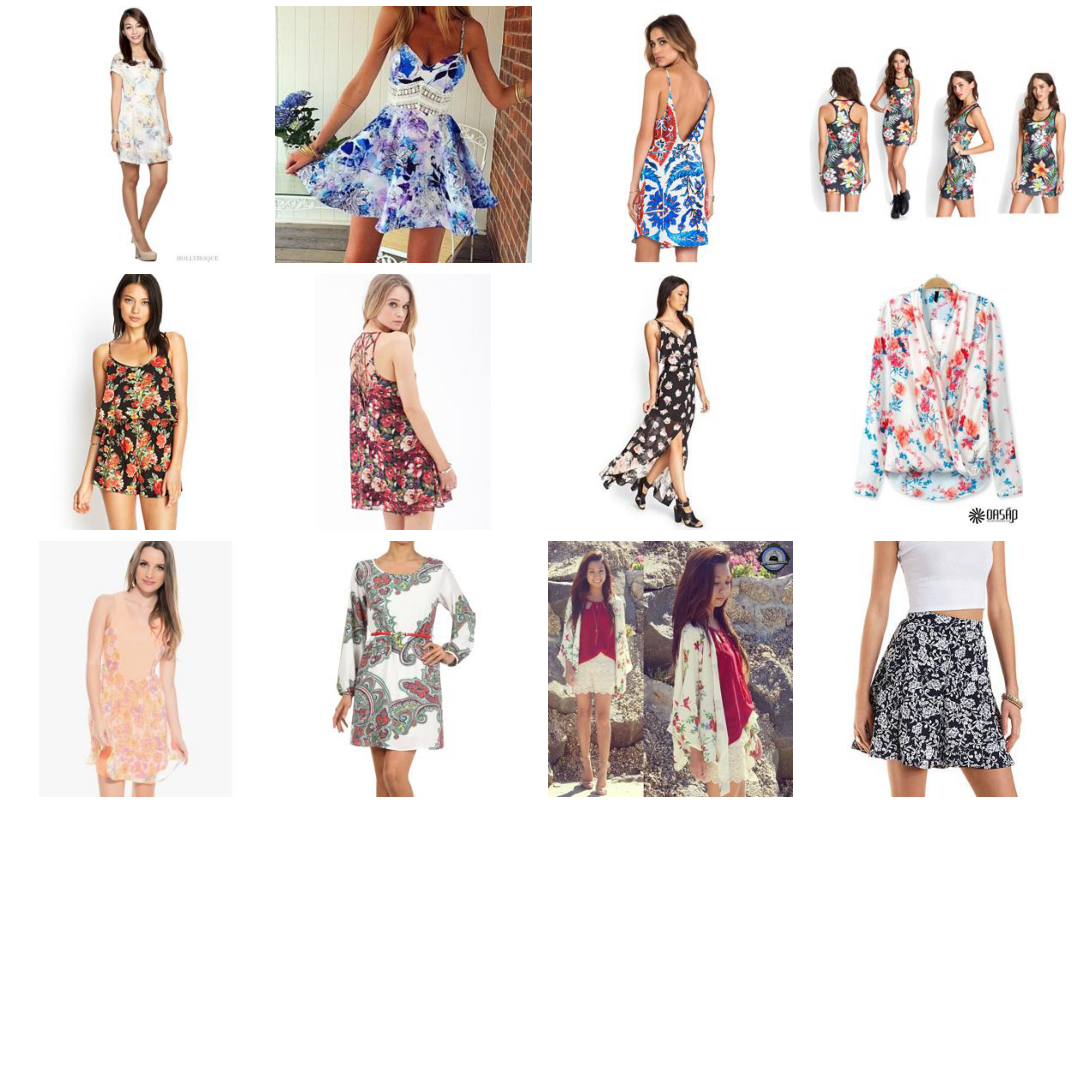

In [ ]:
show_similar_images(outfits_selected, fig_size=[15,15])

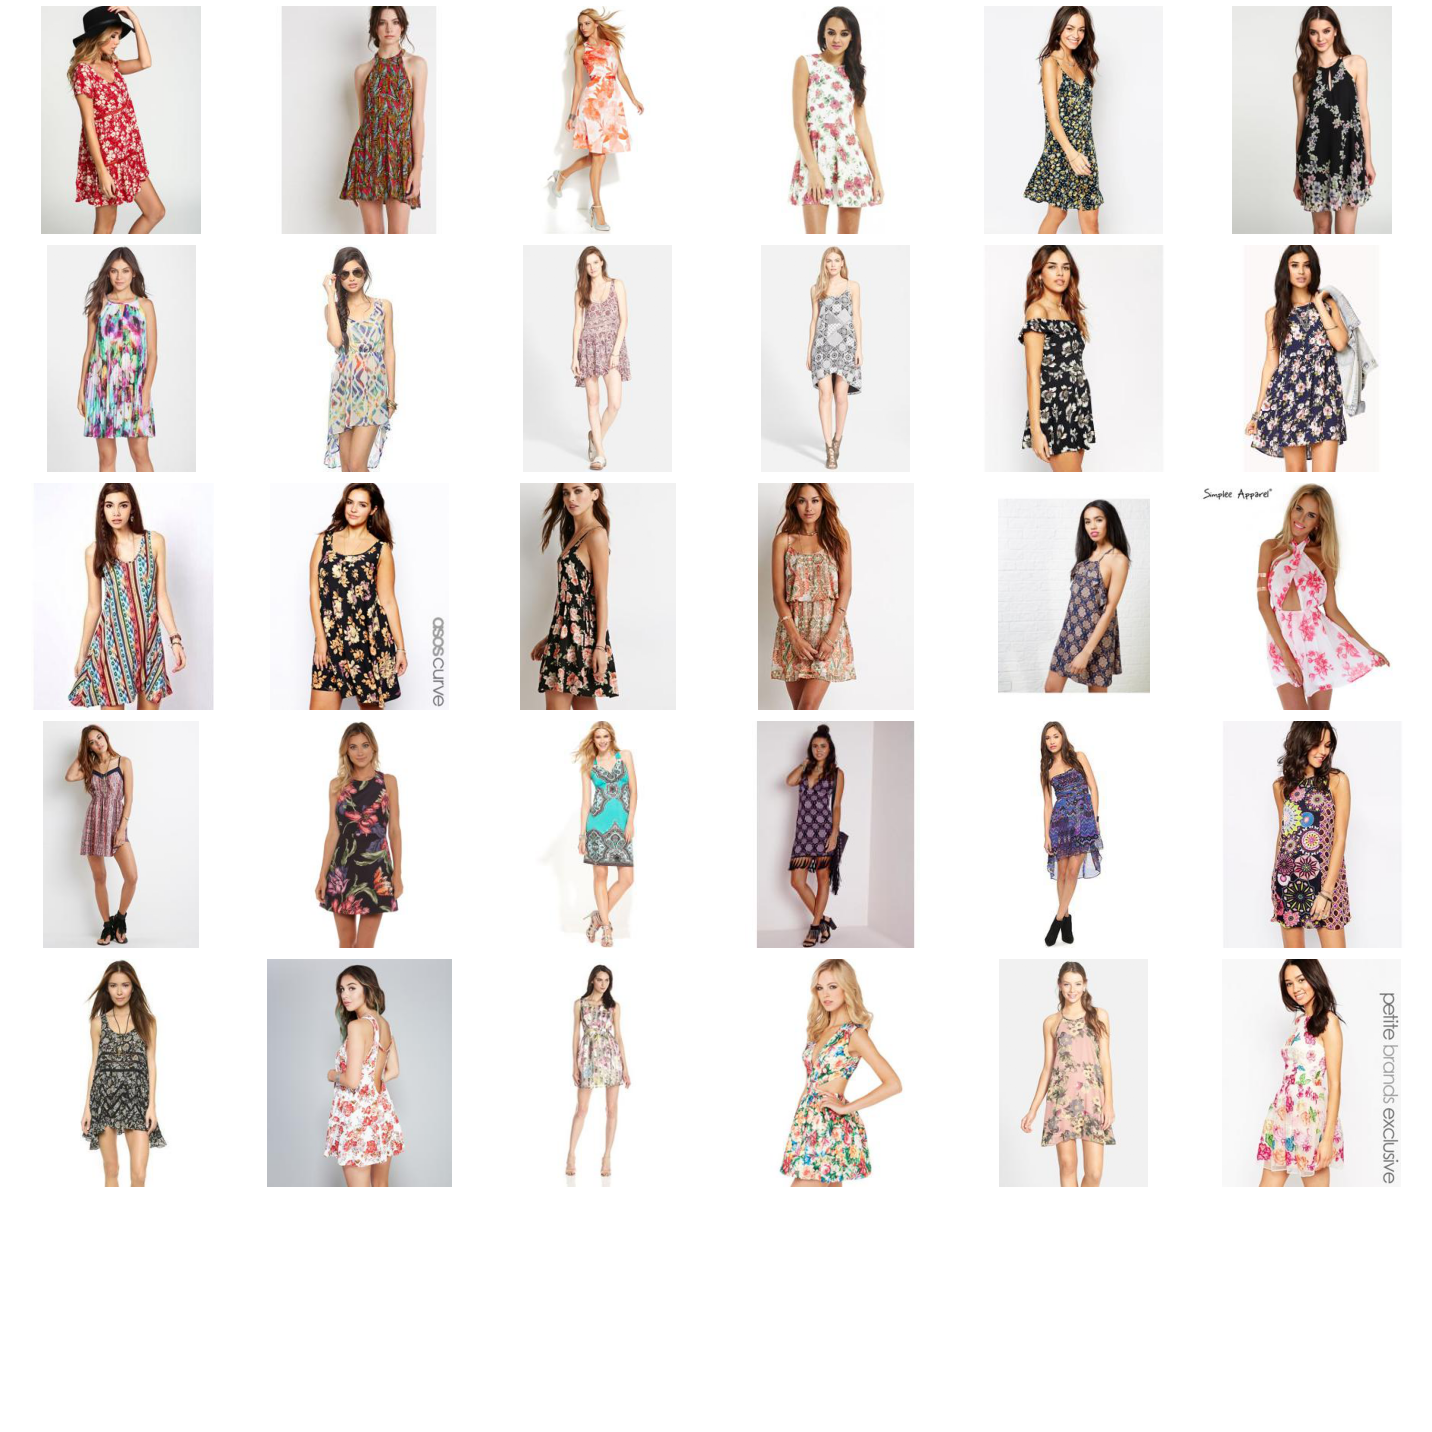

In [ ]:
show_similar_images(similar_images_df, fig_size=[20,20])

# Reflections

* Try to generate new collections based on different fashion styles. Are the results "good"? How can the recommendations be improved? 
* For Annoy, test with different number of trees and distance metrics. Do you observe any difference in terms of speed and items returned? 
* What happens if we swap out the pretrained_model to resnet152? What will you expect from running a "more accurate" model?


